# Importações

In [35]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import xml.etree.ElementTree as xet
from glob import glob
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import time

# Tratando Dataset

In [2]:
!curl -L -o /content/archive.tar.gz "https://www.dropbox.com/scl/fi/khnnv0x8pcpbzlgfevqac/archive.tar.gz?rlkey=55w3pkxp02szjpqw22df7hmn8&dl=0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    300      0 --:--:-- --:--:-- --:--:--   300
100   491    0   491    0     0    225      0 --:--:--  0:00:02 --:--:--   515
100  202M  100  202M    0     0  14.5M      0  0:00:13  0:00:13 --:--:-- 19.9M


In [3]:
!tar xfv /content/archive.tar.gz -C /content

archive/
archive/.DS_Store
archive/images/
archive/annotations/
archive/annotations/Cars213.xml
archive/annotations/Cars207.xml
archive/annotations/Cars398.xml
archive/annotations/Cars367.xml
archive/annotations/Cars401.xml
archive/annotations/Cars415.xml
archive/annotations/Cars373.xml
archive/annotations/Cars429.xml
archive/annotations/Cars47.xml
archive/annotations/Cars53.xml
archive/annotations/Cars165.xml
archive/annotations/Cars171.xml
archive/annotations/Cars159.xml
archive/annotations/Cars84.xml
archive/annotations/Cars90.xml
archive/annotations/Cars91.xml
archive/annotations/Cars85.xml
archive/annotations/Cars158.xml
archive/annotations/Cars170.xml
archive/annotations/Cars164.xml
archive/annotations/Cars52.xml
archive/annotations/Cars46.xml
archive/annotations/Cars428.xml
archive/annotations/Cars414.xml
archive/annotations/Cars372.xml
archive/annotations/Cars366.xml
archive/annotations/Cars400.xml
archive/annotations/Cars399.xml
archive/annotations/Cars206.xml
archive/annotati

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1489257086642221594
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10895294464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8348634850311668125
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-04-16 19:33:47.928038: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 19:33:47.986593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 19:33:48.055325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 19:33:48.055529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [38]:
IMAGE_PATH="/tmp/tcc_alpd/archive/images/"
ANNOTATIONS_PATH = "/tmp/tcc_alpd/archive/annotations/"

In [4]:
def generate_dataframe_from_xml_annotations(directory):
    path = glob(directory)
    labels_dict = dict(image=[], xmin=[], xmax=[], ymin=[], ymax=[])

    for filename in path:
        info = xet.parse(filename)
        root = info.getroot()
        member_object = root.find('object')
        labels_info = member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)

        image_name = os.path.basename(filename)
        image_name = image_name.replace(".xml", ".png")

        labels_dict['image'].append(image_name)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)

    df = pd.DataFrame(labels_dict)
    return df

In [5]:
df = generate_dataframe_from_xml_annotations(ANNOTATIONS_PATH+'*.xml')
df

image  xmin  xmax  ymin  ymax
0    Cars232.png   175   228   174   201
1    Cars289.png   163   271   140   173
2    Cars118.png   193   394   165   217
3     Cars49.png   268   314   171   190
4    Cars241.png   126   241   142   199
..           ...   ...   ...   ...   ...
428  Cars210.png    54   315    90   159
429   Cars70.png   179   213   115   133
430  Cars329.png   166   224   142   176
431  Cars192.png   108   211   150   173
432  Cars332.png   143   260   126   159

[433 rows x 5 columns]

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Tamanho do DataFrame de treinamento:", len(train_df))
print("Tamanho do DataFrame de teste:", len(test_df))

Tamanho do DataFrame de treinamento: 346
Tamanho do DataFrame de teste: 87


In [7]:
test_df

image  xmin  xmax  ymin  ymax
425  Cars245.png    91   164   110   138
75   Cars206.png    95   164   185   206
181  Cars414.png   269   309   206   228
30   Cars367.png   224   382   161   222
364  Cars399.png   106   309    62   161
..           ...   ...   ...   ...   ...
57     Cars5.png   226   242   218   240
124   Cars90.png    77   101   204   225
24   Cars171.png   192   242   146   167
17    Cars47.png     6    48   143   161
66   Cars234.png   160   246   149   171

[87 rows x 5 columns]

In [8]:
def make_dataset(row):
    img = tf.io.read_file(IMAGE_PATH + row)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    return img

train = list(map(make_dataset, train_df.image.values))
test = list(map(make_dataset, test_df.image.values))

2024-04-16 19:33:50.286017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 19:33:50.286239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 19:33:50.286373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 19:33:50.286668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-16 19:33:50.286806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train, (train_df.xmin.values, train_df.ymin.values, train_df.xmax.values, train_df.ymax.values)))
test_ds = tf.data.Dataset.from_tensor_slices((test, (test_df.xmin.values, test_df.ymin.values, test_df.xmax.values, test_df.ymax.values)))

In [11]:
rescaling = layers.Rescaling(scale=1./127.5, offset=-1)
resizing = layers.Resizing(64, 64)

In [12]:
train_ds = train_ds.map(lambda x, y: (resizing(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (resizing(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_ds = train_ds.batch(128).prefetch(tf.data.AUTOTUNE)

In [14]:
test_ds = test_ds.batch(1).prefetch(tf.data.AUTOTUNE)

# Treinando Modelo

In [15]:
img_input = layers.Input(shape=(64, 64, 3))

x = img_input
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
final = layers.Dropout(0.2)(x)

a = layers.Dense(1, name="a")(final)
b = layers.Dense(1, name="b")(final)
c = layers.Dense(1, name="c")(final)
d = layers.Dense(1, name="d")(final)

model = tf.keras.Model(img_input, [a, b, c, d])

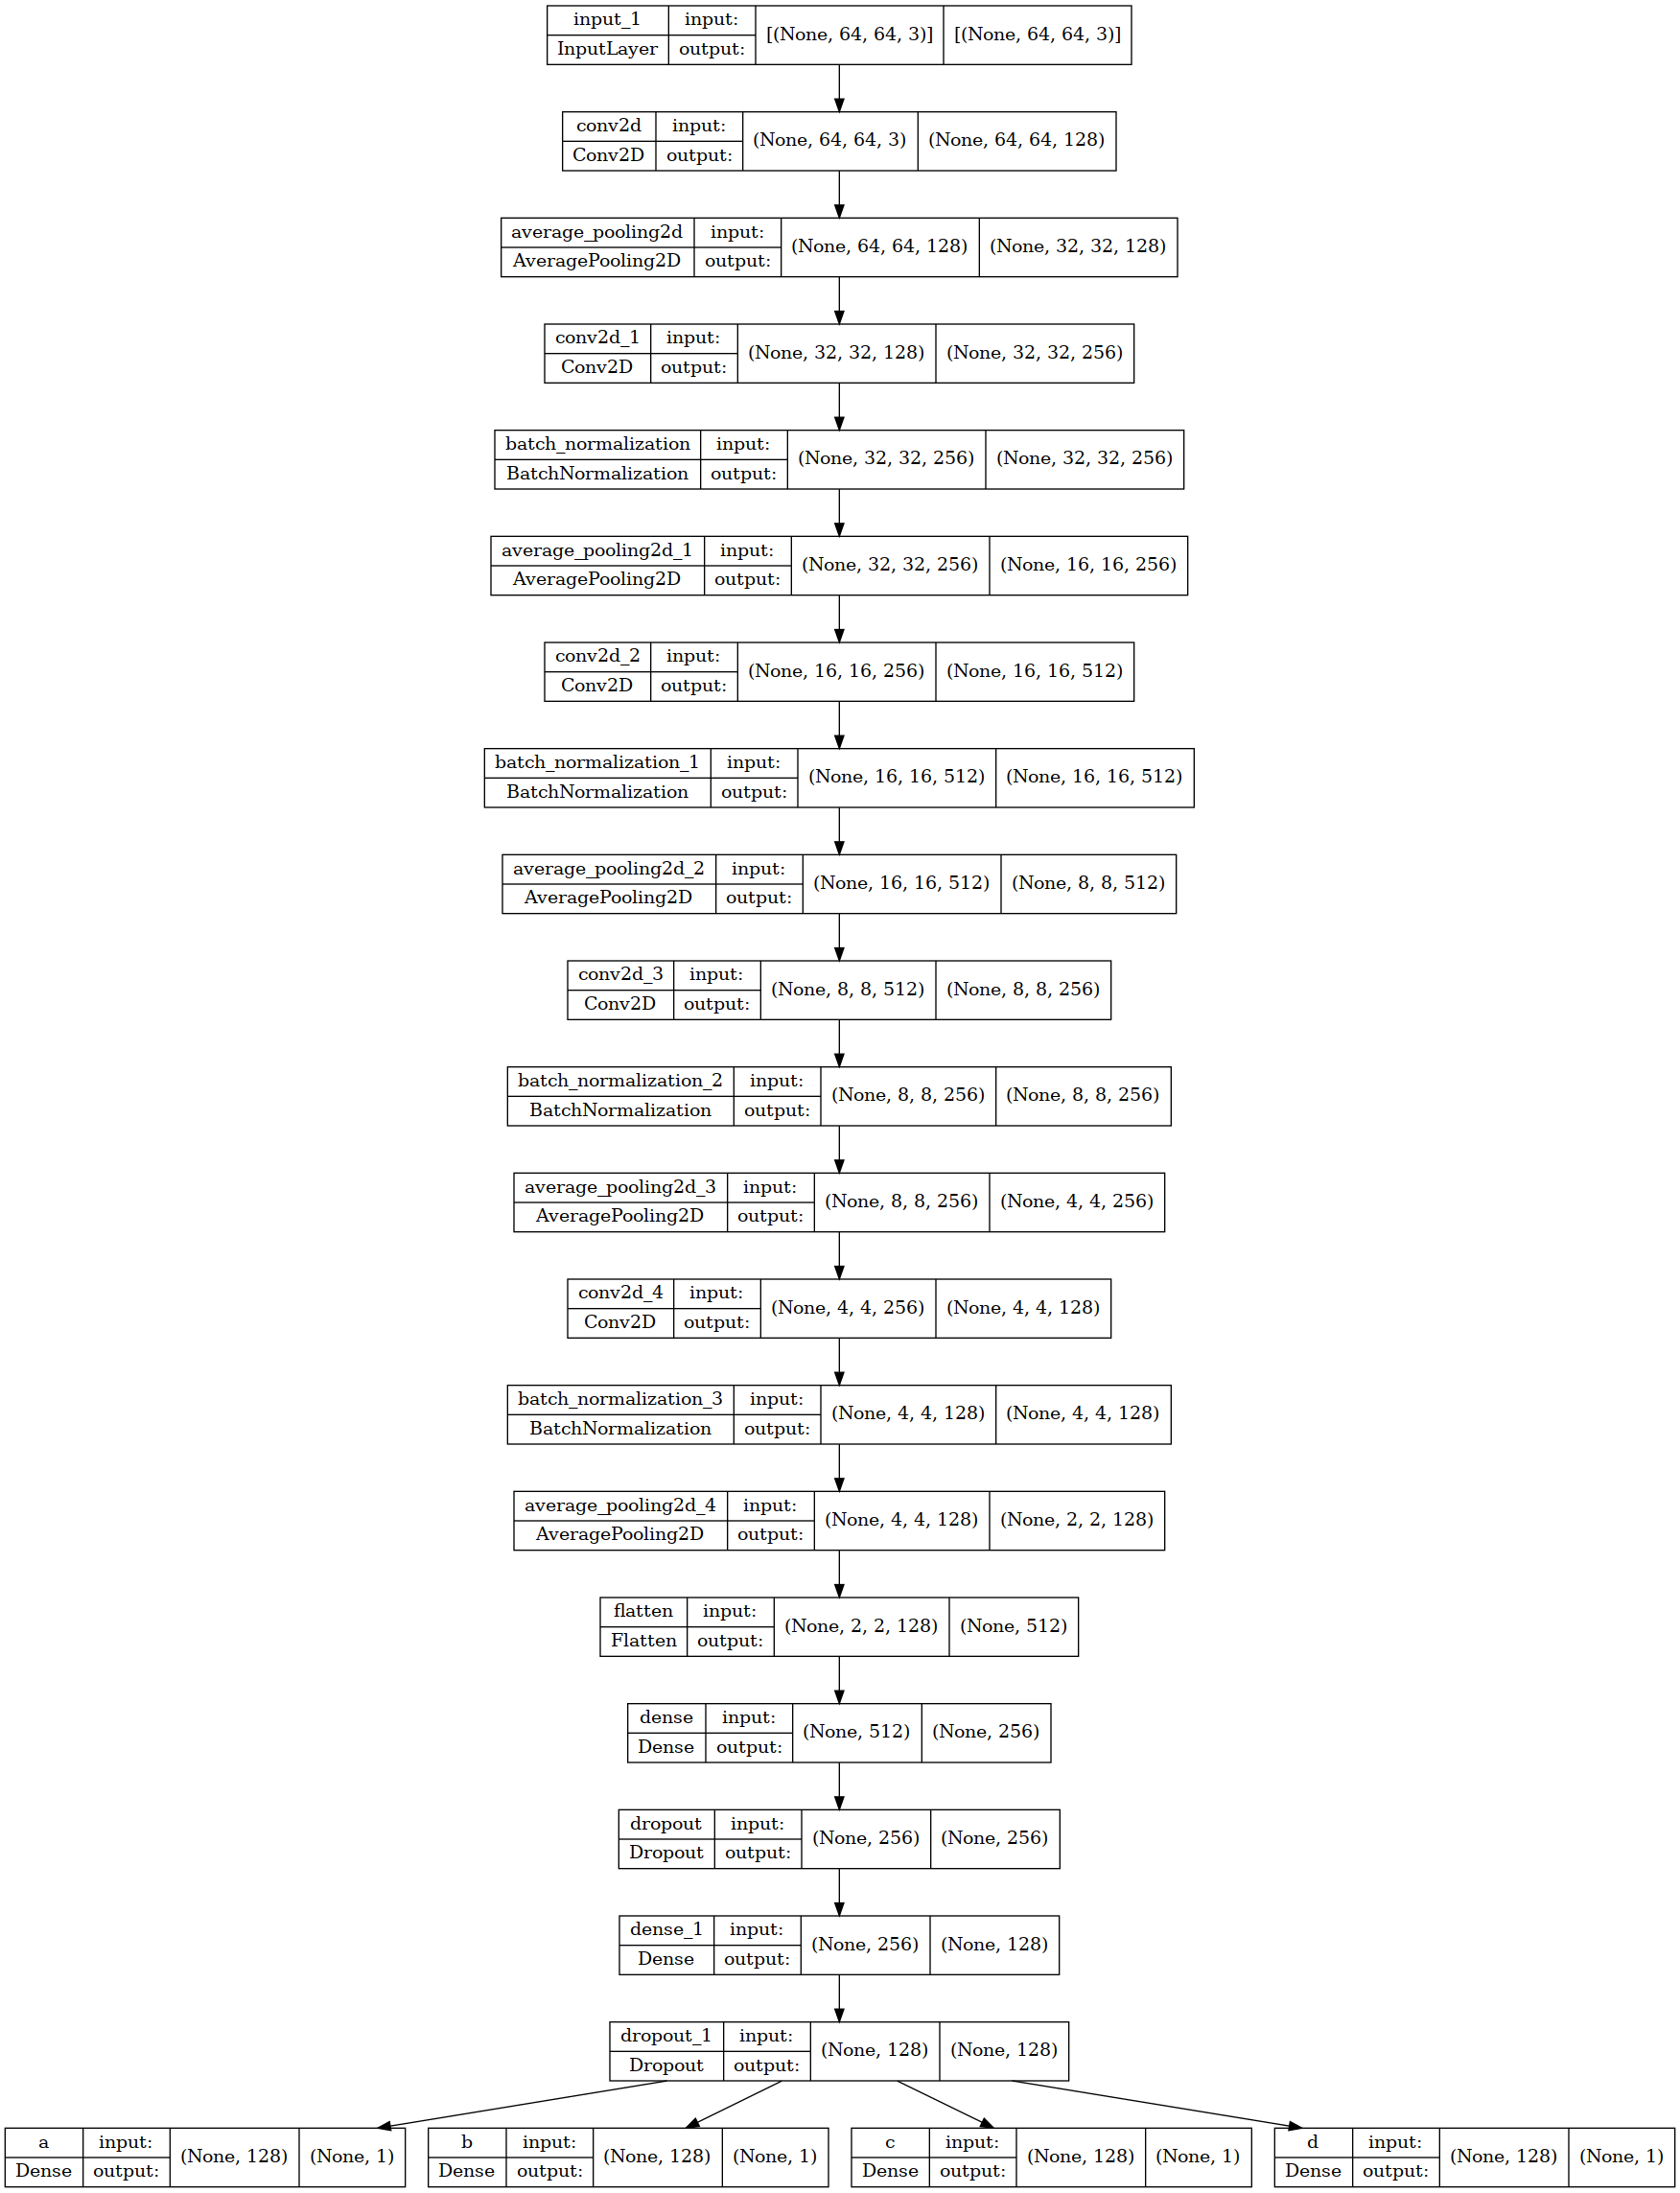

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(optimizer="adam", loss={
    "a": tf.keras.losses.MeanAbsoluteError(),
    "b": tf.keras.losses.MeanAbsoluteError(),
    "c": tf.keras.losses.MeanAbsoluteError(),
    "d": tf.keras.losses.MeanAbsoluteError()
})

In [18]:
model.fit(train_ds, epochs=500)

Epoch 1/500


2024-04-16 19:34:16.573741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8907
2024-04-16 19:34:20.441887: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 10s 610ms/step - loss: 794.0755 - a_loss: 165.1299 - b_loss: 159.9988 - c_loss: 269.3373 - d_loss: 199.6095
Epoch 2/500
3/3 [==============================] - 0s 50ms/step - loss: 766.8619 - a_loss: 158.9333 - b_loss: 152.0061 - c_loss: 261.8775 - d_loss: 194.0450
Epoch 3/500
3/3 [==============================] - 0s 50ms/step - loss: 717.5294 - a_loss: 148.2571 - b_loss: 137.2611 - c_loss: 247.3596 - d_loss: 184.6516
Epoch 4/500
3/3 [==============================] - 0s 50ms/step - loss: 642.3709 - a_loss: 131.4327 - b_loss: 114.5849 - c_loss: 226.0500 - d_loss: 170.3032
Epoch 5/500
3/3 [==============================] - 0s 50ms/step - loss: 538.2781 - a_loss: 109.8765 - b_loss: 83.4924 - c_loss: 196.5887 - d_loss: 148.3205
Epoch 6/500
3/3 [==============================] - 0s 50ms/step - loss: 415.4859 - a_loss: 83.6996 - b_loss: 51.9092 - c_loss: 159.2258 - d_loss: 120.6512
Epoch 7/500
3/3 [==============================] - 0s 50ms/step - loss:

In [29]:
model.save('./scratch_lpd.h5')

# Validando Modelo

In [19]:
def produce_bounding_box(image):
    test_img = tf.io.read_file(image)
    test_img = tf.image.decode_jpeg(test_img, channels=3)
    test_img = tf.image.resize(test_img, (64, 64))
    test_img = tf.expand_dims(test_img, 0)

    outputs = model(test_img)

    width, height = tf.shape(test_img)[2], tf.shape(test_img)[1]
    xmin = int(outputs[0][0][0].numpy())
    ymin = int(outputs[1][0][0].numpy())
    xmax = int(outputs[2][0][0].numpy())
    ymax = int(outputs[3][0][0].numpy())

    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bounded = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

    return bounded

In [22]:
outputs = model.predict(test_ds)


In [23]:
predictions = []

for i in range(len(test_df)):
    image_name = test_df.iloc[i]['image']

    image_path = IMAGE_PATH + image_name

    test_img = tf.io.read_file(image_path)
    test_img = tf.image.decode_jpeg(test_img, channels=3)
    test_img = tf.image.resize(test_img, (64, 64))
    test_img = tf.expand_dims(test_img, 0)

    outputs = model(test_img)

    xmin = int(outputs[0][0][0].numpy())
    ymin = int(outputs[1][0][0].numpy())
    xmax = int(outputs[2][0][0].numpy())
    ymax = int(outputs[3][0][0].numpy())

    predictions.append({'image': image_name,
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax})

predictions_df = pd.DataFrame(predictions)

In [24]:
predictions_df

image  xmin  ymin  xmax  ymax
0   Cars245.png    90   110   170   138
1   Cars206.png    59   190   192   231
2   Cars414.png   172   187   250   214
3   Cars367.png   237   159   364   206
4   Cars399.png   105    72   306   170
..          ...   ...   ...   ...   ...
82    Cars5.png   116   168   182   205
83   Cars90.png   173   114   232   150
84  Cars171.png   200   148   249   173
85   Cars47.png   352   115   403   138
86  Cars234.png   163   150   245   172

[87 rows x 5 columns]

In [26]:
true_positive = false_positive = false_negative = 0
iou_threshold = 0.5

for _, pred_row in predictions_df.iterrows():
    test_row = test_df[test_df['image'] == pred_row['image']]
    
    if len(test_row) > 0:
        intersection_xmin = max(pred_row['xmin'], test_row.iloc[0]['xmin'])
        intersection_ymin = max(pred_row['ymin'], test_row.iloc[0]['ymin'])
        intersection_xmax = min(pred_row['xmax'], test_row.iloc[0]['xmax'])
        intersection_ymax = min(pred_row['ymax'], test_row.iloc[0]['ymax'])
        
        intersection_area = max(0, intersection_xmax - intersection_xmin) * max(0, intersection_ymax - intersection_ymin)
        pred_area = (pred_row['xmax'] - pred_row['xmin']) * (pred_row['ymax'] - pred_row['ymin'])
        test_area = (test_row.iloc[0]['xmax'] - test_row.iloc[0]['xmin']) * (test_row.iloc[0]['ymax'] - test_row.iloc[0]['ymin'])
        union_area = pred_area + test_area - intersection_area
        
        iou = intersection_area / union_area
        
        if iou >= iou_threshold:
            true_positive += 1
        else:
            false_positive += 1
    else:
        false_positive += 1

false_negative = len(test_df) - true_positive

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print("Precisão:", precision)
print("Recall:", recall)

Precisão: 0.45977011494252873
Recall: 0.45977011494252873


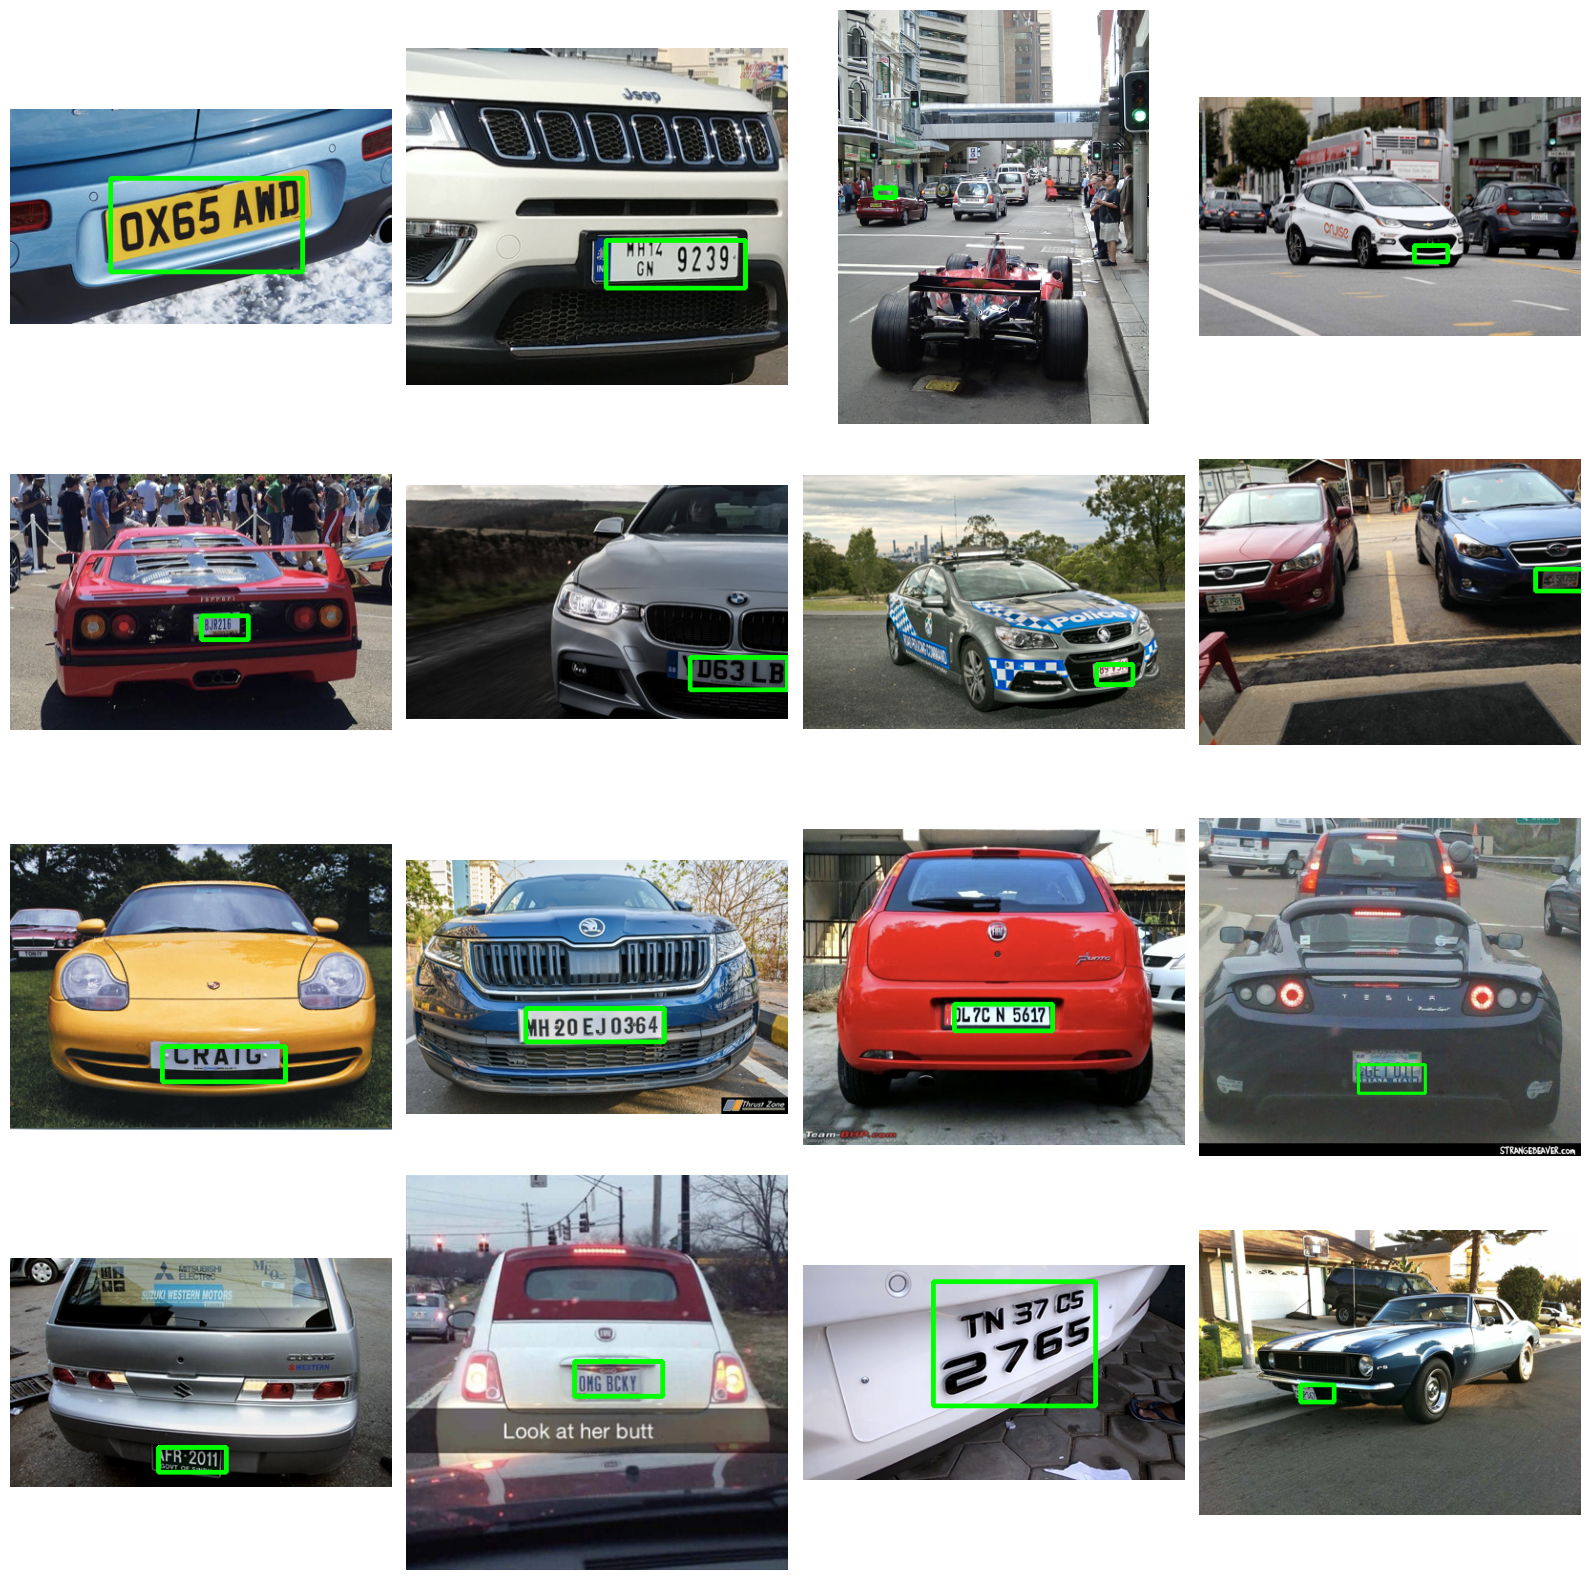

In [33]:
def produce_bounding_box(directory, model):
    images = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')]

    random_images = random.sample(images, 16)

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()

    for ax, image in zip(axes, random_images):
        test_img = tf.io.read_file(image)
        test_img = tf.image.decode_png(test_img, channels=3)
        test_img = tf.image.resize(test_img, (64, 64))
        test_img = tf.expand_dims(test_img, 0)

        outputs = model(test_img)

        xmin = int(outputs[0][0][0].numpy())
        ymin = int(outputs[1][0][0].numpy())
        xmax = int(outputs[2][0][0].numpy())
        ymax = int(outputs[3][0][0].numpy())

        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        bounded = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

        ax.imshow(bounded)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

produce_bounding_box(IMAGE_PATH, model)

In [42]:
def predict_time(image_paths, num_images=100):
    random_images = random.sample(image_paths, num_images)
    
    start_time = time.time()
    
    for image_path in random_images:
        test_img = tf.io.read_file(image_path)
        test_img = tf.image.decode_jpeg(test_img, channels=3)
        test_img = tf.image.resize(test_img, (64, 64))
        test_img = tf.expand_dims(test_img, 0)

        outputs = model(test_img)

    end_time = time.time()
    
    elapsed_time = end_time - start_time
    print("Tempo total de predição para 100 imagens aleatórias: {:.2f} segundos".format(elapsed_time))
    
image_paths = [os.path.join(IMAGE_PATH, filename) for filename in os.listdir(IMAGE_PATH)]
predict_time(image_paths)

Tempo total de predição para 100 imagens aleatórias: 1.50 segundos
